# load libraries and data

In [6]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
from pathlib import Path
import os

dataset_name = 'enbackfMRI'
train_out = Path(os.getcwd()+'/data/IdeationNAttempt_'+dataset_name+'_train.csv')
test_out =Path(os.getcwd()+'/data/IdeationNAttempt_'+dataset_name+'_test.csv')


train_data= pd.read_csv(train_out)
test_data= pd.read_csv(test_out)
target ='ideation_attempt.x'
unused_feat = ['Set', 'Suicidalideation.x', 'subjectkey', 'abcd_site', 'Unnamed: 0', 'kfold',
               'src_subject_id','interview_date','gender','eventname']
n=0
start_mri = 0;
for i in test_data.columns:
    #print(i)
    if i =='tfmri_nback_all_0.back_beta_cort.destrieux_g.and.s.frontomargin.lh':
        start_mri =n
    n +=1

    
mri = list(test_data.columns[start_mri:])
#print(mri)
Num_FOLDS  = 3
# the number of feature that you want to show 
Num_feat = 20

In [16]:
test_data['subjectkey']

0      NDARINVFR2DW1WV
1      NDARINVWN8UC0FU
2      NDARINVL6EFKUHV
3      NDARINVYTJ92RU3
4      NDARINV67TUZJU7
            ...       
289    NDARINV2W07991D
290    NDARINV1KP8VFVR
291    NDARINV36JGB4H6
292    NDARINV94N0G9TC
293    NDARINVHEW2AUBP
Name: subjectkey, Length: 294, dtype: object

# Fine object featrues

In [7]:
train_data_processed = train_data.fillna(0).reset_index(drop=True)
features = [ col for col in train_data_processed.columns if col not in unused_feat + [target] + mri] 

object_feat =[]

j=0
for i in test_data[features].dtypes:
    #print(j)
    if i == 'object':
        print(test_data[features].columns[j])
        object_feat.append(test_data[features].columns[j])
    j+=1
    
print(object_feat)

features = [ col for col in train_data_processed.columns if col not in unused_feat + [target] +mri +object_feat] 


[]


# For drawing ROC curve graph

In [8]:
def rocvis(true , prob , label ) :
    from sklearn.metrics import roc_curve
    if type(true[0]) == str :
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        true = le.fit_transform(true)
    else :
        pass
    fpr, tpr, thresholds = roc_curve(true, prob)
    plt.plot(fpr, tpr, marker='.', label = label  )


# For getting feature importance 

In [9]:
    


def feature(Num_feat, clf, test_data_processed, features):
    importance =clf.feature_importances_
    #plt.plot(importance)
    #plt.show()
    labels_importance=importance.argsort()[::-1]

    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 
    

    for i in range (Num_feat):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])

    return important_features.reset_index(drop=True)

# Define function for preprocessing for Cross validation

In [10]:
def preproecessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1

    train_data_processed["kfold"] = -1

    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

    kf = KFold(n_splits=NUM_FOLDS)

    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
        train_data_processed.loc[val_, 'kfold'] = fold
    print("done preprocessing")
    return train_data_processed, test_data_processed

# Finding best parameters

In [11]:
# Augmented
import torch
import itertools
from sklearn.metrics import confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm


def find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    # Store maximum auc
    max_auc= 0
    # Store maximum hypterparameter set
    max_hy = []
    # define hyperparameter space
    
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    # Orginal hyperparameter space 
    """
    # define hyperparameter space (quick version)
    n_ = [4,8]
    lr_ = [2e-2,1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99]
    ss_ = [10, 20]
    """
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    
    for hy in tqdm(h_space):
        clf = TabNetClassifier(n_a = hy[0],
                               n_d = hy[0],
                               optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                               scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               verbose=0
                               )
        """
        clf.fit(X_train, Y_train, X_valid, Y_valid, patience=10, batch_size=256, max_epochs=200)
        """
        clf.fit(X_train=X_train, y_train=Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
                eval_name=['train', 'valid'], eval_metric=['auc'],
                max_epochs=200 , patience=20,batch_size=256)
        
        #clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200) (Recommended)
        preds_acc = clf.predict(X_test)
        preds_prob = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
        test_acc = accuracy_score(preds_acc, Y_test)
        
        #tn, fp, fn, tp = confusion_matrix(y_true=Y_test, y_pred = clf.predict(X_test))
        print("--------Valid score: {} --------------------".format(clf.best_cost))
        print("--------Test auc: {} Test acc:{}-------------".format(test_auc, test_acc) )
        if test_auc>max_auc:
            max_hy = hy
            max_auc = test_auc
    return max_hy

# Train with best parameter

In [13]:
def bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy, features):
 
    hy = max_hy
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                               )
    """
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=10, batch_size=256, max_epochs=200)
    """
    clf.fit(X_train=X_train, y_train=Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
                eval_name=['train', 'valid'], eval_metric=['auc'],
                max_epochs=200 , patience=20,batch_size=256)
    
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    TN, FP, FN, TP = confusion_matrix(y_true=Y_test, y_pred = clf.predict(X_test)).ravel()
    sensitivity =TP/(TP+FN)
    specificity =TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    Accuracy = TP+FP/(TN+ FP+ FN + TP)
        
    
    
    print("Max hy:" ,hy)
    print("--------Valid score: {} --------------------".format(clf.best_cost))
    print("FINAL TEST SCORE(max) test auc: {} test acc: {}".format(test_auc, test_acc))
    return test_auc, clf, preds_prob, sensitivity, specificity, PPV, NPV, Accuracy 

# Run function, Split data and and cross validation. This needs to be modified

In [79]:
def run(train_data_processed, test_data_processed, fold, Num_feat, features):
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values
    
    # subject key
    name_test = test_data['subjectkey'].values
    
    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    name_train = df_train['subjectkey']
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    
    name_valid =df_valid['subjectkey']
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("---------------------------------------Training Begining for fold {}-------------------------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    # Start training
    max_hy = find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test)
    
    # if you want to just test the code, you should use this
    #max_hy = h_space[0]
    print("Found maximum hyperparmeter, now work with that")
    
    test_auc, clf, preds_prob, sensitivity, specificity, PPV, NPV, Accuracy = bestpar_tuning(X_train, Y_train, 
                                                                                            X_valid, Y_valid, 
                                                                                            X_test, Y_test, 
                                                                                            max_hy, features)
    
    import_feat=feature(Num_feat, clf, test_data_processed, features)
    preds_val_prob = clf.predict_proba(X_valid)

    return test_auc, Y_test, X_test, clf, preds_prob, import_feat, Y_valid, preds_val_prob, name_test, name_train, name_valid 


# Final training function

In [25]:
    
def hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat):
    CV_auc_all = []
    train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
    import_feat_every = pd.DataFrame()
    features_all = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 
    # in rsfMRI, those are some how wrong data.
    features_mri = [ col for col in mri if col not in 'rsfmri_cor_network.gordon_subcort.aseg_visitid']  
    features_pheno = [ col for col in train_data_processed.columns if col not in unused_feat + [target] 
                +mri] 
    print("all")
    test_auc_all, Y_test_all, X_test_all, clf_all, preds_prob_all, import_feat_all, Y_valid_all, preds_val_prob_all, name_test_all, name_train_all, name_valid_all = run(train_data_processed,
                                                                         test_data_processed,
                                                                         0, 
                                                                         Num_feat, 
                                                                         features_all
                                                                                                                            
                                             )
    print("pyschosocial")
    test_auc_pheno, Y_test_pheno,X_test_pheno, clf_pheno, preds_prob_pheno, import_feat_pheno, Y_valid_pheno, preds_val_prob_pheno, name_test_pheno, name_train_pheno, name_valid_pheno = run(train_data_processed, 
                                                                                                                                         test_data_processed, 
                                                                                                                                         0, 
                                                                                                                                         Num_feat, 
                                                                                                                                         features_pheno)
  
    print("mri")
    test_auc_mri, Y_test_mri, X_test_mri, clf_mri, preds_prob_mri, import_feat_mri, Y_valid_mri, preds_val_prob_mri, name_test_mri, name_train_mri, name_valid_mri = run(train_data_processed, 
                                                                                                                          test_data_processed,
                                                                                                                          0,
                                                                                                                          Num_feat,
                                                                                                                          features_mri)
  
    
  
    return name_test_all, name_train_all, name_valid_all, name_test_pheno, name_train_pheno, name_valid_pheno, name_test_mri, name_train_mri, name_valid_mri, X_test_all, clf_all, X_test_pheno, clf_pheno, X_test_mri, clf_mri, test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri, Y_test_all , preds_prob_all, Y_test_pheno , preds_prob_pheno, Y_test_mri , preds_prob_mri, Y_valid_all, preds_val_prob_all, Y_valid_pheno, preds_val_prob_pheno, Y_valid_mri, preds_val_prob_mri
    


# Main code 

In [26]:
name_test_all, name_train_all, name_valid_all, name_test_pheno, name_train_pheno, name_valid_pheno, name_test_mri, name_train_mri, name_valid_mri, X_test_all, clf_all, X_test_pheno, clf_pheno, X_test_mri, clf_mri, test_auc_all, test_auc_pheno, test_auc_mri, import_feat_all, import_feat_pheno, import_feat_mri, Y_test_all , preds_prob_all, Y_test_pheno , preds_prob_pheno, Y_test_mri , preds_prob_mri, Y_valid_all, preds_val_prob_all, Y_valid_pheno, preds_val_prob_pheno, Y_valid_mri, preds_val_prob_mri= hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat)


done preprocessing
all
---------------------------------------Training Begining for fold 1-------------------------------
Found maximum hyperparmeter, now work with that

Early stopping occured at epoch 39 with best_epoch = 19 and best_valid_auc = 0.73573
Best weights from best epoch are automatically used!
Max hy: (4, 0.02, 0.01, 0.95, 10)
--------Valid score: 0.735727593079345 --------------------
FINAL TEST SCORE(max) test auc: 0.7424684159378038 test acc: 0.5


<ipython-input-13-71ae2522d117>:25: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP/(TP+FP)


pyschosocial
---------------------------------------Training Begining for fold 1-------------------------------
Found maximum hyperparmeter, now work with that

Early stopping occured at epoch 35 with best_epoch = 15 and best_valid_auc = 0.74248
Best weights from best epoch are automatically used!
Max hy: (4, 0.02, 0.01, 0.95, 10)
--------Valid score: 0.742479275584183 --------------------
FINAL TEST SCORE(max) test auc: 0.7416817066962839 test acc: 0.5
mri


<ipython-input-13-71ae2522d117>:25: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP/(TP+FP)


---------------------------------------Training Begining for fold 1-------------------------------
Found maximum hyperparmeter, now work with that

Early stopping occured at epoch 28 with best_epoch = 8 and best_valid_auc = 0.55839
Best weights from best epoch are automatically used!
Max hy: (4, 0.02, 0.01, 0.95, 10)
--------Valid score: 0.558387611565235 --------------------
FINAL TEST SCORE(max) test auc: 0.5093710953769263 test acc: 0.5


<ipython-input-13-71ae2522d117>:25: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP/(TP+FP)


# Getting results

In [28]:
valid_auc_all = roc_auc_score (Y_valid_all, preds_val_prob_all[:,1])
valid_auc_pheno = roc_auc_score (Y_valid_pheno, preds_val_prob_pheno[:,1])
valid_auc_mri = roc_auc_score (Y_valid_mri, preds_val_prob_mri[:,1])


def classify (preds_prob_all, Y_test, line):
    y_pred_all = []
    for x in preds_prob_all[:,1]:
        if x > line:
            y_pred_all.append(1)
        else:
            y_pred_all.append(0)
    y_pred_all=np.array(y_pred_all)
    test_acc = accuracy_score(y_pred_all, Y_test)
    #print(test_acc)
    return y_pred_all, test_acc

def find_best_boundary(preds_prob_all,Y_test):
    results =[]
    idx =[]
    for i in  np.arange(0.01, 0.35, 0.01):
   
        idx.append(i)
        _,test_acc =classify(preds_prob_all,Y_test, i)
        results.append(test_acc)

    results
    num_idx=results.index(max(results))
    best_idx =idx[num_idx]
    #print(f'best_classify_boundary {best_idx}')
    y_pred_all,test_acc =classify(preds_prob_all, Y_test, best_idx)
    #print(f'best ACC= {test_acc}')
    return best_idx

def confusion_stuff (Y_test, preds_prob_all):
    best_idx=find_best_boundary(preds_prob_all,Y_test)
    y_pred_all, test_acc =classify (preds_prob_all, Y_test, 0.15)
    TN, FP, FN, TP = confusion_matrix(y_true=Y_test, y_pred = y_pred_all).ravel()
    print(TN,FP)
    print(FN,TP)
    
    sensitivity =TP/(TP+FN)
    specificity =TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    Accuracy = test_acc
    return sensitivity, specificity, PPV, NPV, Accuracy

def makeround(sensitivity_all, specificity_all, PPV_all, NPV_all, Accuracy_all):
    lists = sensitivity_all, specificity_all, PPV_all, NPV_all, Accuracy_all
    new_lists=[]
    for list in lists:
        new_list =  round(list*100,2)
        new_lists.append(new_list)
    
    return new_lists[0], new_lists[1], new_lists[2], new_lists[3], new_lists[4]
        
print(dataset_name)
print("All")
sensitivity_all, specificity_all, PPV_all, NPV_all, Accuracy_all = confusion_stuff(Y_test_all, preds_prob_all)
sensitivity_all, specificity_all, PPV_all, NPV_all, Accuracy_all = makeround(sensitivity_all, specificity_all, PPV_all, NPV_all, Accuracy_all)
print(f"sensitivity {sensitivity_all}% specificity {sensitivity_all}% PPV {sensitivity_all}% NPV {NPV_all}% Accuracy {Accuracy_all}% Valid_AUC {round(valid_auc_all*100,2)}% Test_AUC {round(test_auc_all*100,2)}% " )

print("psychosocial")
sensitivity_pheno, specificity_pheno, PPV_pheno, NPV_pheno, Accuracy_pheno = confusion_stuff(Y_test_pheno, preds_prob_pheno)
sensitivity_pheno, specificity_pheno, PPV_pheno, NPV_pheno, Accuracy_pheno= makeround(sensitivity_pheno, specificity_pheno, PPV_pheno, NPV_pheno, Accuracy_pheno)
print(f"sensitivity {sensitivity_pheno}% specificity {specificity_pheno}% PPV {PPV_pheno}% NPV {NPV_pheno}% Accuracy {Accuracy_pheno}% Valid_AUC {round(valid_auc_pheno*100,2)}% Test_AUC {round(test_auc_pheno*100,2)}%")

print("MRI")
sensitivity_mri, specificity_mri, PPV_mri, NPV_mri, Accuracy_mri = confusion_stuff(Y_test_mri, preds_prob_mri)
sensitivity_mri, specificity_mri, PPV_mri, NPV_mri, Accuracy_mri = makeround(sensitivity_mri, specificity_mri, PPV_mri, NPV_mri, Accuracy_mri )
print(f"sensitivity {sensitivity_mri}% specificity {specificity_mri}% PPV {PPV_mri}% NPV {NPV_mri}% Accuracy {Accuracy_mri}% Valid_AUC {round(valid_auc_mri*100,2)}% Test_AUC {round(test_auc_mri*100,2)}%")

enbackfMRI
All
72 75
18 129
sensitivity 87.76% specificity 87.76% PPV 87.76% NPV 80.0% Accuracy 68.37% Valid_AUC 73.57% Test_AUC 74.25% 
psychosocial
87 60
33 114
sensitivity 77.55% specificity 59.18% PPV 65.52% NPV 72.5% Accuracy 68.37% Valid_AUC 74.25% Test_AUC 74.17%
MRI
147 0
147 0
sensitivity 0.0% specificity 100.0% PPV nan% NPV 50.0% Accuracy 50.0% Valid_AUC 55.84% Test_AUC 50.94%


<ipython-input-28-c2c179458fd6>:44: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP/(TP+FP)


# Draw ROC curve

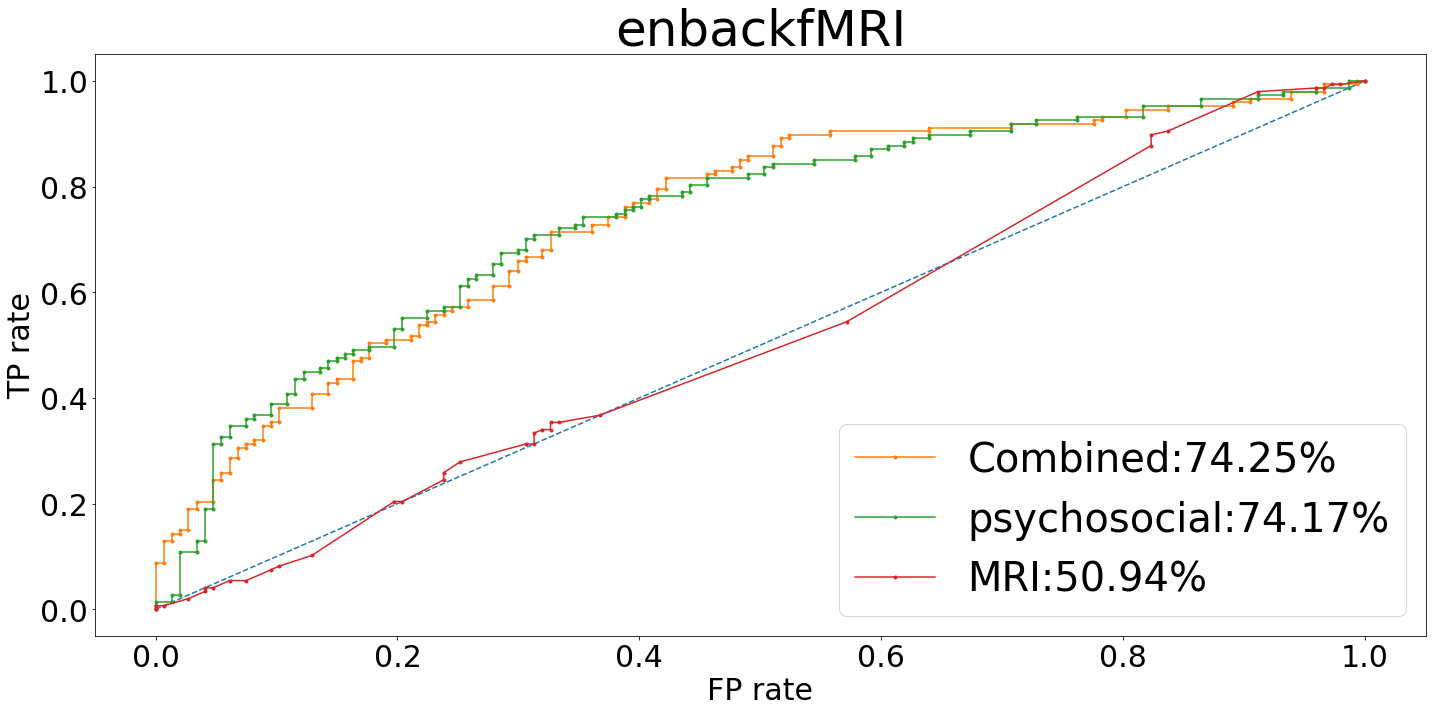

In [29]:
fig , ax = plt.subplots(figsize= (20,10))
plt.plot([0, 1], [0, 1], linestyle='--')
rocvis(Y_test_all , preds_prob_all[:,1] , f"Combined:{round(test_auc_all*100, 2)}%")
rocvis(Y_test_pheno , preds_prob_pheno[:,1] , f"psychosocial:{round(test_auc_pheno*100, 2)}%")
rocvis(Y_test_mri , preds_prob_mri[:,1] , f"MRI:{round(test_auc_mri*100, 2)}%")
    #rocvis(caty_Test , catprob[:,1] , "CatBoost")
dataset_name="enbackfMRI"

plt.legend(fontsize = 40)
plt.title(dataset_name, fontsize= 50)
plt.xlabel("FP rate", fontsize =30)
plt.ylabel("TP rate", fontsize =30)
plt.xticks(size = 30)
plt.yticks(size = 30)

plt.tight_layout()
plt.savefig(f'{dataset_name}_ROC.png')

# For model interpretation. with subjectkey below datas are needed

name_test_all, name_train_all, name_valid_all,
name_test_pheno, name_train_pheno, name_valid_pheno, 
name_test_mri, name_train_mri, name_valid_mri, 
Y_test_all , preds_prob_all,
Y_test_pheno , preds_prob_pheno, 
Y_test_mri , preds_prob_mri, 
Y_valid_all, preds_val_prob_all, 
Y_valid_pheno, preds_val_prob_pheno,
Y_valid_mri, preds_val_prob_mri

In [68]:
def save_prob_with_true(Y_test,preds_prob, subjectkey, testORvalid, modeltype):
    
    combined_model=pd.DataFrame({f"subjectkey_{testORvalid}_{modeltype}": subjectkey, f"Y_{testORvalid}_{modeltype}":Y_test, f"preds_prob_{testORvalid}_{modeltype}" :preds_prob[:,1]} )
    combined_model.to_csv(f"{dataset_name}_combined_forROC_{modeltype}_{testORvalid}.csv")
    return combined_model

In [72]:
result_test_all = save_prob_with_true(Y_test_all, preds_prob_all, name_test_all, "test", "all")
result_valid_all = save_prob_with_true(Y_valid_all, preds_val_prob_all, name_valid_all, "valid", "all")

result_test_pheno = save_prob_with_true(Y_test_pheno, preds_prob_pheno, name_test_pheno, "test", "psychosocial")
result_valid_pheno = save_prob_with_true(Y_valid_pheno, preds_val_prob_pheno, name_valid_pheno, "valid", "psychosocial")

result_test_mri = save_prob_with_true(Y_test_mri, preds_prob_mri, name_test_mri, "test", "mri")
result_valid_mri = save_prob_with_true(Y_valid_mri, preds_val_prob_mri, name_valid_mri, "valid", "mri")



# save feature importance

In [30]:
import_feat_every=pd.concat([import_feat_all,import_feat_pheno, import_feat_mri])

import_feat_every.to_csv(f"{dataset_name}_features.csv")

import_feat_every 


,feature name,ratio
0,PPSP_distress,0.228752
1,Depress.CBCL,0.112053
2,Internal.and.External.Comobidity,0.065614
3,tfmri_nback_all_posface.vs.neutface_beta_cort....,0.043772
4,tfmri_nback_all_negface.vs.neutface_beta_cort....,0.036385
5,sex,0.031474
6,tfmri_nback_all_2.back_beta_cort.destrieux_s.f...,0.030814
7,high.educ,0.028307
8,tfmri_nback_all_place_beta_cort.destrieux_g.ci...,0.027658
9,tfmri_nback_all_face.vs.place_beta_cort.destri...,0.027560


# Draw AUC per epochs and loss per epochs

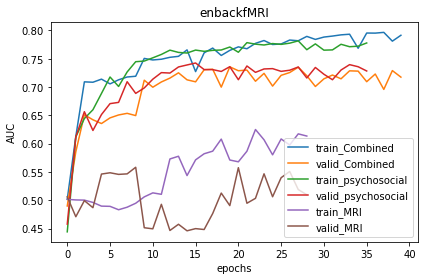

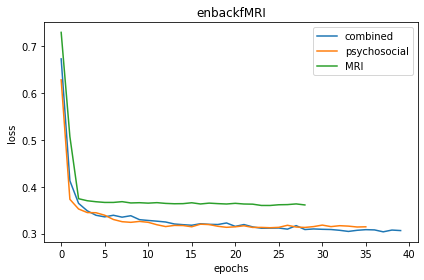

In [31]:
feature_names=["Combined", "psychosocial", "MRI"]
clfs = [clf_all, clf_pheno, clf_mri ]
simple_name = "enbackfMRI"

def error_plot(clf):
    plt.plot(clf.history['train_auc'])
    plt.plot(clf.history['valid_auc'])
    


for i in range(3):
    error_plot(clfs[i])

plt.legend([f'train_{feature_names[0]}', f'valid_{feature_names[0]}', 
           f'train_{feature_names[1]}', f'valid_{feature_names[1]}',
           f'train_{feature_names[2]}', f'valid_{feature_names[2]}'])
plt.title(f'{simple_name}')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.tight_layout()

plt.savefig(f'AUC_per_epochs {simple_name}.png')

plt.show()          


feature_names=["combined", "psychosocial", "MRI"]
clfs = [clf_all, clf_pheno, clf_mri ]

def error_plot(clf):
    plt.plot(clf.history['loss'])
    


for i in range(3):
    error_plot(clfs[i])

plt.legend([f'{feature_names[0]}', 
           f'{feature_names[1]}',
           f'{feature_names[2]}'])
plt.title(f'{simple_name}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()

plt.savefig(f'loss_per_epochs {simple_name}.png')

plt.show()          



# Model save 

In [32]:
def saveclf(clf,name):
    clf.save_model(f'{simple_name}_{name}')
saveclf(clf_all,"all")
saveclf(clf_pheno,"combined")
saveclf(clf_mri,"mri")


Successfully saved model at enbackfMRI_all.zip
Successfully saved model at enbackfMRI_combined.zip
Successfully saved model at enbackfMRI_mri.zip
